In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# load parquet
PARQUET_PATH = '../base/base_de_dados.parquet'

df = pd.read_parquet(PARQUET_PATH)
df = df[
     [
        'id',
        'approved',
        'created_at',
        'analysis_status',
        'kind',
        'finished'
     ]]
     
df = df[df['finished'] == True].drop(columns=['finished'], inplace=False)

#convert created_at to datetime
df['created_at'] = pd.to_datetime(df['created_at'])
df['month'] = df['created_at'].dt.month
df = df.drop(columns=['created_at'], inplace=False)

In [11]:
# download all .jpeg files from base-teste-facematch-analise-dispositivo-dev S3
# and save to local folder
import boto3
import os
import tqdm

# Initialize a session using Amazon S3
boto3.setup_default_session(profile_name='will_development')
s3 = boto3.client('s3')

bucket_name = 'base-teste-facematch-analise-dispositivo-dev'

# Create a local directory to store the files
local_folder = '/home/joao.cassiano/Documentos/will/projetos/facematch_interno/base/imagens'
os.makedirs(local_folder, exist_ok=True)

# List and download files from the bucket
def download_jpeg_files():
    paginator = s3.get_paginator('list_objects_v2')
    for page in paginator.paginate(Bucket=bucket_name):
        for obj in tqdm.tqdm(page.get('Contents', [])):
            key = obj['Key']
            if key.endswith('.jpeg'):
                local_file_path = os.path.join(local_folder, key)
                s3.download_file(bucket_name, key, local_file_path)
                #print(f'Downloaded {key} to {local_file_path}')

download_jpeg_files()


  1%|          | 7/1000 [00:02<06:56,  2.38it/s]


KeyboardInterrupt: 

In [6]:
#get number of occurences of each status
df.analysis_status.value_counts()

analysis_status
BIOMETRIC_AUTHENTICATED              19447
SUSPECTED_FRAUD                       2995
BIOMETRIC_TRANSACTION_BAD_QUALITY      433
BIOMETRIC_NEEDS_REVALIDATION           372
UNREADABLE_PHOTO                       228
UNREADABLE_BIOMETRIC_FACE                2
Name: count, dtype: int64

<Figure size 1000x500 with 0 Axes>

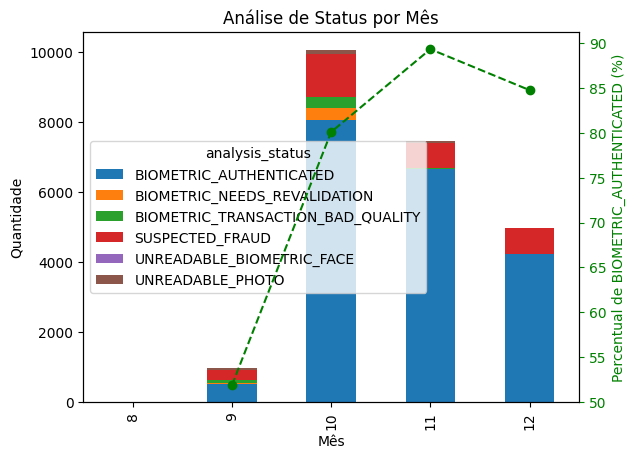

In [14]:
import matplotlib.pyplot as plt

# Seu código original
plt.figure(figsize=(10,5))
ax = df.groupby('month').analysis_status.value_counts().unstack().plot(kind='bar', stacked=True)
plt.title('Análise de Status por Mês')
plt.ylabel('Quantidade')
plt.xlabel('Mês')

# Criando o segundo eixo y
ax2 = ax.twinx()

# Calculando o percentual de cada status de análise por mês
status_percentages = df.groupby('month').analysis_status.value_counts(normalize=True).unstack().multiply(100)

# Escolha um status específico para plotar, ou uma média, etc. Aqui está um exemplo:
# Substitua 'specific_status' pelo status específico que você quer plotar
specific_status = 'BIOMETRIC_AUTHENTICATED'  # Substitua isso pelo status desejado
status_percentage = status_percentages[specific_status]

# Plotando o percentual no segundo eixo y
ax2.plot(ax.get_xticks(), status_percentage, color='green', marker='o', linestyle='dashed')
ax2.set_ylabel(f'Percentual de {specific_status} (%)', color='green')
ax2.tick_params(axis='y', colors='green')

# Mostrando o plot
plt.show()


In [13]:
import numpy as np
import pandas as pd
import glob

# Seu código existente para obter os caminhos das imagens
images_paths = glob.glob('../base/imagens/*.jpeg') 

fotos_cadastro = [foto.split('/')[-1] for foto in images_paths if ('selfie' in foto and not('transaction_selfie') in foto) or 'transaction_unico' in foto]
fotos_comparacao = [foto.split('/')[-1] for foto in images_paths if not(foto.split('/')[-1] in fotos_cadastro)]

print(
f'''
Fotos de cadastro: {len(fotos_cadastro)}\n\n
Fotos de comparação: {len(fotos_comparacao)}\n\n
Fotos no total: {len(df)}\n\n
'''
)

# Inicializando colunas no DataFrame
df['registration_image'] = np.nan
df['comparision_image'] = np.nan

# Iterando sobre os IDs e atualizando o DataFrame
for id in df['id'].unique():
    # Encontrando as imagens correspondentes ao ID
    registration_imgs = [foto for foto in fotos_cadastro if id in foto]
    comparision_imgs = [foto for foto in fotos_comparacao if id in foto]
    
    # Verifica se encontrou alguma imagem e atualiza o DataFrame
    if registration_imgs:
        df.loc[df['id'] == id, 'registration_image'] = registration_imgs[0]  # Supõe que haja no máximo uma imagem de cadastro por ID
    if comparision_imgs:
        df.loc[df['id'] == id, 'comparision_image'] = comparision_imgs[0]  # Supõe que haja no máximo uma imagem de comparação por ID



Fotos de cadastro: 9188


Fotos de comparação: 5188


Fotos no total: 23559





/tmp/ipykernel_22775/291428581.py:31: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'c1f483cd-0ead-4c83-bd7f-2434e89cd7ba_selfie.jpeg' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['id'] == id, 'registration_image'] = registration_imgs[0]  # Supõe que haja no máximo uma imagem de cadastro por ID
/tmp/ipykernel_22775/291428581.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'c1f483cd-0ead-4c83-bd7f-2434e89cd7ba_transaction_selfie.jpeg' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[df['id'] == id, 'comparision_image'] = comparision_imgs[0]  # Supõe que haja no máximo uma imagem de comparação por ID


In [20]:
filtered_df = df.dropna(subset=['registration_image', 'comparision_image'])

# Save the filtered DataFrame as a Parquet file
parquet_filename = '../base/filtered_data.parquet'
filtered_df.to_parquet(parquet_filename)

print(f"Filtered DataFrame saved as '{parquet_filename}'")


Filtered DataFrame saved as '../base/filtered_data.parquet'
